# Nowcast Statistical Analysis
## An assessment of Sea Surface Temperature (SST) CeNCOOS(nowcast) and observed data in the Bay Area.
### This notebook presents an analysis of CeNCOOS predictions for a location where we have observed SSS recorded.
### First, we load necessary packages and function. We prompt user date input for CeNCOOS. We have necessary functions for data extraction.
### Second, we fetch and process CeNCOOS (netCDF format) from an online server and processed using the xarray package. We fetch observed data. We group data by day and month.
### Third, we merge both data sets and produce summary statistics and plot.

In [1]:
#Looking at Nowcast and Observed Data for SST

from typing import Tuple, Dict, List

import numpy as np
import xarray as xr
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.relpath('../src'))
from statistical_analysis import statistical_analysis


In [2]:
#user input for nowcast dates

#format of lists [year,month,day]

#Nowcast
min_date_CeNCOOS = [2021,8,1] #initial nowcast date desired
max_date_CeNCOOS = [2021,12,16] #tomorrows date

#need folder specifications

In [3]:
#downloading CeNOOS data

def pad_with_zeros(x: int) -> str:
    return str(x) if x > 9 else '0' + str(x)


def convert_time_tuple_to_str(x: Tuple[int, int, int]):
    """
    Converts a YYYY-MM-DD date, provided as a tuple, into a string

    :param x: tuple with year, month, day as integers
    :return: date string: YYYY-MM-DD, len=8, with 0s padding MM and DD as needed
    """
    return str(x[0]) + '-' + pad_with_zeros(x[1]) + '-' + pad_with_zeros(x[2])


def convert_str_to_date(date_string: str) -> np.datetime64:
    return np.datetime64(date_string)


def get_cencoos_historical(
        lon: float,
        lat: float,
        min_date: Tuple[int, int, int],
        max_date: Tuple[int, int, int],
        output_folder: str
) -> str:
    """
    Retrieve sea surface nowcast and forecast from 3km CeNCOOS (SST, SSS, u, v)
    :param lon: longitude of interest
    :param lat: latitude of interest
    :param min_date: current date (tuple with year, month, day)
    :param max_date: last day of forecast (tuple with year, month, day)
    :param output_folder: name of folder where downloaded netCDF file is stored
    :return: path to new netCDF file created in device that holds the data
    """
    min_time = convert_str_to_date(convert_time_tuple_to_str(min_date) + 'T00:00:00')
    max_time = convert_str_to_date(convert_time_tuple_to_str(max_date) + 'T23:59:59')
    print('Connecting to CeNCOOS')
    try:
        full_ds = xr.open_dataset('http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_DAS.nc')
    except Exception as e:
        output_file = 'Could not connect!'
    else:
        ti = full_ds.coords["time"]
        if ti[-1].data < min_time:  # CeNCOOS is not always up to date :-(
            output_file = 'Last timestamp on CeNCOOS less than min_time'
        else:
            print('Fetching data chunk')
            chunk = full_ds.loc[dict(depth=0,
                                     lat=slice(lat - 0.015, lat + 0.015),
                                     lon=slice(np.mod(lon - 0.015, 360), np.mod(lon + 0.015, 360)),
                                     time=(ti >= min_time) & (ti <= max_time))]
            output_file = output_folder + 'cencoos.nc'
            chunk = (
                chunk
                    .load()
                    .rename({'temp': 'sst', 'salt': 'sss'})
                    .assign_coords(lon=(((chunk.lon + 180) % 360) - 180))
             )
            print('Storing to disk')
            chunk.to_netcdf(output_file)
     
    return output_file


def extract_data_from_nc(nc_folder: str, ocean_var: str) -> pd.DataFrame:
    """
    Read netCDF file from disk and extract data from one ocean variable
    :param nc_folder: location of 'cencoos.nc' file
    :param ocean_var: one of 'sst' (sea surface temperature),
                             'sss' (sea surface salinity),
                             'u' (surface zonal current speed),
                             'v' (surface meridional current speed)
                             'zeta'(sea surface height)
    """
    if not ocean_var in ['sst', 'sss', 'u', 'v', 'zeta']:
        raise Exception('Variable not in file')
    b = xr.open_dataset(nc_folder + 'cencoos.nc')
    df = pd.DataFrame({'time': np.array(b['time']),
                      ocean_var: np.array([x[0][0] for x in b[ocean_var]])})
    return df

        

In [4]:
folder = '/Users/amygizel/Documents/Seadog Internship/Model_Analysis/data/' #specify desired folder to save


get_cencoos_historical(lon=-122.6,
                       lat=37.8,
                       min_date=(min_date_CeNCOOS[0],min_date_CeNCOOS[1], min_date_CeNCOOS[2]), #initial nowcast date desired
                       max_date=(max_date_CeNCOOS[0],max_date_CeNCOOS[1], max_date_CeNCOOS[2]), #tomorrows date
                       output_folder= folder)

Connecting to CeNCOOS
Fetching data chunk
Storing to disk


'/Users/amygizel/Documents/Seadog Internship/Model_Analysis/data/cencoos.nc'

In [5]:
big_df = extract_data_from_nc(nc_folder= folder, ocean_var='sst')

big_df.head(5)

,time,sst
0,2021-08-01 03:00:00,11.242288
1,2021-08-01 09:00:00,11.313168
2,2021-08-01 15:00:00,11.417974
3,2021-08-01 21:00:00,11.888391
4,2021-08-02 03:00:00,11.531926


In [6]:
#finding mean and merging in csv file

big_df['month'] = [int(x) for x in big_df['time'].astype(str).str[5:7]]

big_df['day'] = [int(x) for x in big_df['time'].astype(str).str[8:10]]

big_df = big_df.drop(columns=["time"])

big_df=big_df.groupby(by = ["day","month"]).mean()

big_df.columns = [' '.join(col) for col in big_df.columns]

big_df= big_df.reset_index(drop = False)

big_df= big_df.dropna(subset = ["s s t"])

big_df= big_df.rename(columns={"s s t": "CeNCOOS"})

big_df = big_df.sort_values(['month','day']).reset_index(drop = True)

big_df

,day,month,CeNCOOS
0,1,8,11.465455
1,2,8,11.613916
2,3,8,11.523390
3,4,8,11.009763
4,5,8,10.454076
...,...,...,...
132,11,12,13.468299
133,12,12,13.417053
134,13,12,13.523521
135,14,12,13.470802


In [7]:
#adding observed data

url = 'https://www.ndbc.noaa.gov/data/realtime2/46237.txt'

buoy = pd.read_csv(url, skiprows = [1], delim_whitespace=True)

buoy = buoy.rename(columns={"MM": "month","DD":"day"})

buoy = buoy.drop(columns = ["#YY","hh","mm","WDIR","WSPD","GST","WVHT","DPD","APD","MWD","PRES","ATMP","DEWP","VIS","PTDY","TIDE"])

buoy = buoy.groupby(by = ["day","month"]).mean()

buoy.columns = [' '.join(col) for col in buoy.columns]

buoy = buoy.reset_index(drop = False)

buoy = buoy.dropna(subset = ["W T M P"])

buoy = buoy.rename(columns={"W T M P": "Observed"})

buoy = buoy.sort_values(['month','day']).reset_index(drop = True)

buoy.head(5)

,day,month,Observed
0,1,11,14.854167
1,2,11,14.972917
2,3,11,15.061702
3,4,11,15.127660
4,5,11,15.160417


In [8]:
#merging Observed and Nowcast Data
df = pd.merge(left=big_df, right=buoy[["Observed","day","month"]], on=["day","month"], how='inner')

df = df.sort_values(['month','day']).reset_index(drop = True)

df.head(20)

,day,month,CeNCOOS,Observed
0,1,11,12.516178,14.854167
1,2,11,12.003427,14.972917
2,3,11,11.855498,15.061702
3,4,11,12.233976,15.127660
4,5,11,12.210361,15.160417
5,6,11,12.549644,15.060417
6,7,11,12.663171,14.843478
7,8,11,12.867436,14.572340
8,9,11,12.937649,14.208333
9,10,11,13.207421,14.621277


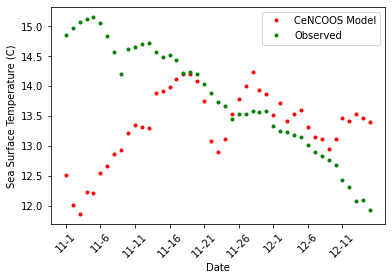

In [9]:
#plotting graph

plt.plot(df.index,df['CeNCOOS'],'r.', label= 'CeNCOOS Model')
plt.plot(df.index,df['Observed'],'g.', label= 'Observed')

#actual data add to plot -->
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Sea Surface Temperature (C)')
my_xticks =  []

axis_seperation = 5
for x in range(0,len(df["month"])): 
    date = str(df["month"][x])+ "-"+ str(df["day"][x])
    if x % axis_seperation == 0:
        my_xticks.append(date)

plt.xticks(df.index[::axis_seperation], my_xticks)

plt.show()



In [10]:
statistical_analysis(None,df,"CeNCOOS","Observed",1)

0.9751670474547358 is the mean bias for lead time of None days
1.3180721001893503 is the root mean squared error for lead time of None days
0.4 is the percent gross error for lead time of None days
6.903515758598431 is the mean absolute percentage error None days
